# Titanic Survival Prediction
**Goal:** Predict survival using classical ML.  
**Dataset:** Titanic (Seaborn)  
**Model:** Random Forest (pipeline with preprocessing)  
**Metrics:** Accuracy, Precision, Recall, F1-score  

---

## Imports


In [1]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- Reproducibility ---
SEED = 42
np.random.seed(SEED)


## Load and Inspect Dataset


In [2]:
# Load dataset
titanic = sns.load_dataset("titanic")
print(titanic.head())
print(titanic.info())

# Basic cleanup: drop missing values in key features
titanic = titanic.dropna(subset=["age", "embarked", "fare"])

   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-nu

## Feature Selection


In [3]:
# Features and target
X = titanic[["pclass", "sex", "age", "sibsp", "parch", "fare", "embarked"]]
y = titanic["survived"]

# Identify numeric and categorical columns
num_cols = ["age", "sibsp", "parch", "fare", "pclass"]
cat_cols = ["sex", "embarked"]


## 4️⃣ Preprocessing + Pipeline

In [4]:
# Preprocessing
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# Pipeline with Random Forest
clf = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(random_state=SEED))
])


## 5️⃣ Hyperparameter Tuning


In [5]:
# Hyperparameter grid
param_grid = {
    "model__n_estimators": [50, 100],
    "model__max_depth": [None, 5, 10],
    "model__min_samples_split": [2, 4]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
grid_search.fit(X, y)

print("Best Params:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)


Best Params: {'model__max_depth': 10, 'model__min_samples_split': 4, 'model__n_estimators': 50}
Best CV Score: 0.8272333300502315


## 6️⃣ Train & Evaluate

In [6]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# Train best model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Predictions
y_pred = best_model.predict(X_test)

## 7️⃣ Classification Metrics

              precision    recall  f1-score   support

           0       0.82      0.84      0.83        85
           1       0.75      0.72      0.74        58

    accuracy                           0.79       143
   macro avg       0.78      0.78      0.78       143
weighted avg       0.79      0.79      0.79       143



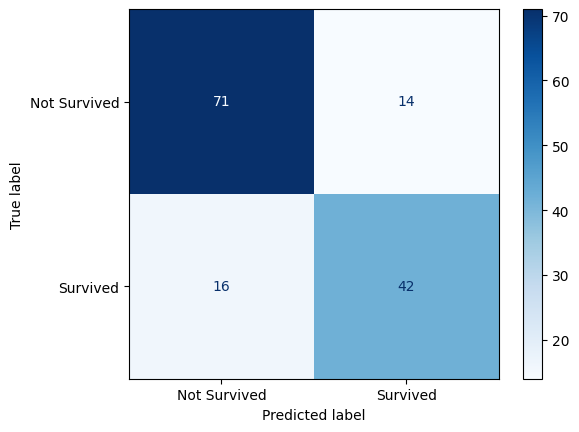

In [7]:
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Not Survived", "Survived"])
disp.plot(cmap="Blues", values_format="d")
plt.show()


## 8️⃣ Feature Importance

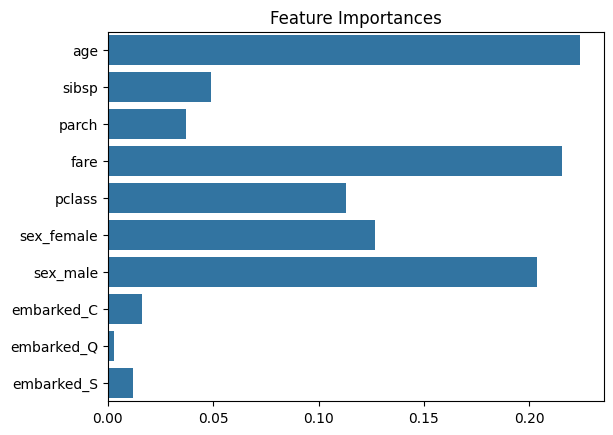

In [8]:
# Feature importances from Random Forest
importances = best_model.named_steps["model"].feature_importances_
features = num_cols + list(best_model.named_steps["preprocess"].named_transformers_["cat"].get_feature_names_out())

sns.barplot(x=importances, y=features)
plt.title("Feature Importances")
plt.show()
